TODO
jason briner - long term perspectives of greenland ice sheet position
- if current approx margin configuration is where it _generally_ is during interglacials then it would *make sense* that there are lots of overdeepenings just up-ice.
- Lindbäck, K., R. Pettersson, A. L. Hubbard, S. H. Doyle, D. van As, A. B. Mikkelsen, and A. A. Fitzpatrick. 2015. Subglacial water drainage, storage and piracy beneath the Greenland ice sheet. Geophysical Research Letters 42:7606–14.
see lindback references in ross et al., 2018
- Lindbäck, K., R. Petterson, S. H. Doyle, C. Helanow, P. Jansson, S. S. Kristensen, L. Stenseng, R. Forsberg, and A. L. Hubbard. 2014. High-resolution ice thickness and bed topography of a land-terminating section of the Greenland ice sheet. Earth System Science Data 6:331–38.
is there evidence of *preferential* erosion signature

lake massu
simon mudd, mikael attal - what are lakes? 
rivers **cannot** erode below base level.

TODO
send PN velocity figures and summary paragraph

In [1]:
from dask.distributed import Client
import pandas as pd
import itslive
import geopandas as gpd
from shapely.geometry import Polygon
from shapely import box
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.dates import date2num, DateFormatter, YearLocator
import seaborn as sns
import xrspatial as xrs
import numpy as np
import xarray as xr
from tqdm import tqdm
from IPython import display
import importlib
import imagery
import utils
import get_velocity

client = Client()
print(f'dask dashboard: {client.dashboard_link}')

dask dashboard: http://127.0.0.1:8787/status


In [2]:
_ = importlib.reload(utils)
_ = importlib.reload(get_velocity)
_ = importlib.reload(imagery)

In [5]:
lines = gpd.read_file('../data/streams_v2.geojson')

In [8]:
V = {}
for row in tqdm(lines.sample(1).itertuples()):
    print(f'working on #{row.Index}')
    try:
        V[row.Index] = get_velocity.CentreLiner(geo=row.geometry,
                                                buff_dist=1_000,
                                                index=row.Index,
                                                filter_cube=False,
                                                get_annual_median=False,
                                                get_rgb=False)
        display.clear_output(wait=True)
    except Exception as e:
        print(f'#{row.Index} did not work because\n{e}')
        continue

1it [01:16, 76.54s/it]


In [9]:
def filter_df(self, ddt_range, **kwargs):
    _df, _ = get_velocity.Tools.filter_ddt(self.line_df,
                                           ddt_range)
    _var = kwargs.get('var', 'v')
    _val = kwargs.get('val', None)
    _col = kwargs.get('col', 'cumul_dist')
    _mad = kwargs.get('mad', 5)
    
    if _val is None:
        print('no val supplied - finding distance where v is peak')
        _df = _df.loc[_df[_col] == (_df
                                            .set_index(_col)
                                            .groupby('mid_date')[_var]
                                            .idxmax()
                                            .value_counts()
                                            .idxmax())
                    ].sort_values(by='mid_date')
    else:
        _df = utils.nearest(_df, _col, _val).sort_values(by='mid_date')
        
    if _mad:
        _df = get_velocity.Tools.filter_mad(_df, _var, n=_mad)
        _df = _df.sort_values(by='mid_date')
        
    return _df
    
def plot_datedt_bars(self, ddt_range, ax, **kwargs):
    from matplotlib.collections import LineCollection
    _c = kwargs.get('c', 'tab:blue')
    _lw = kwargs.get('lw', 1)
    
    _df = filter_df(self, ddt_range, **kwargs)
    
    _vcol = LineCollection(list(zip(
        list(zip(date2num(_df['acquisition_date_img1']), _df['v'])),
        list(zip(date2num(_df['acquisition_date_img2']), _df['v']))
        )),
                           linewidth=_lw,
                           color=_c)
    
    ax.add_collection(_vcol, autolim=False)
    
    ax.set(
        ylim=(_df['v'].agg([np.nanmin, np.nanmax])),
        xlim=(date2num(_df['acquisition_date_img1'].min()),
              date2num(_df['acquisition_date_img2'].max())
              ))
    
def plot_datedt_rolling_median(self, ddt_range, ax, **kwargs):
    _c = kwargs.get('c', 'tab:blue')
    _lw = kwargs.get('lw', 1)
    _val = kwargs.get('val', None)
    _col = kwargs.get('col', None)
    _var = kwargs.get('var', 'v')
    _mad = kwargs.get('mad', 5)
    _window = kwargs.get('window', '21d')

    _df = filter_df(self, ddt_range, **kwargs)
    _df = _df.loc[~_df[_var].isna()]
    (_df.rolling(_window,
                on='mid_date',
                min_periods=3)['v','mid_date']
    .median()
    .plot(x='mid_date', y='v', ax=ax, c=_c, lw=_lw))

    # ax.axhline(_df['v'].median(), c='k')

no val supplied - finding distance where v is peak
MAD: 7.0
no val supplied - finding distance where v is peak
MAD: 7.0


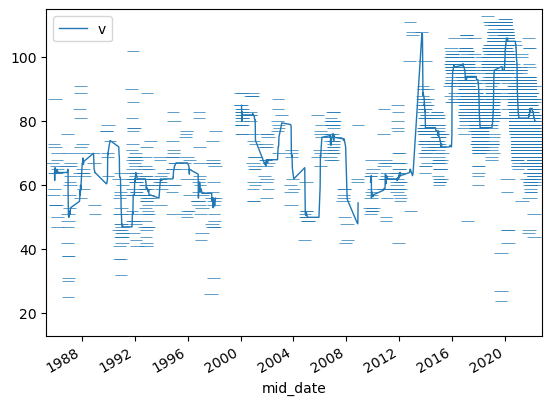

In [18]:
tmp_idx = list(V.keys())[0]
fig, ax = plt.subplots()

get_velocity.Plotters.rolling_median(V[tmp_idx],
                                     ('335d', '395d'),
                                    #  val=0,
                                     col='cumul_dist',
                                     var='v',
                                     mad=5,
                                     window='365d',
                                     ax=ax)

get_velocity.Plotters.date_dt_bars(V[tmp_idx],
                                   ddt_range=('335d', '395d'),
                                   ax=ax,
                                   lw=0.5,
                                   var='v')

- look at underlying dodgy velocity images
TODO look at GRIMpP and MEASUREs

TODO
- PN thinks that relative change is sufficient to *control* for variations in glacier geometry (read: width/size).
- most interested in *relative* change of velocity over final few kilometers.
    - i.e. 

- it all comes from the same raw processed v data

## imagery

In [ ]:
study_sites = gpd.read_file('../data/potential_study_sites_v1.geojson')
study_sites = study_sites.loc[study_sites['notes'].isin(['yes', 'maybe'])]
study_sites.reset_index(drop=True, inplace=True)
study_sites_5k = study_sites.buffer(5_000).to_crs(4326)

In [ ]:
items = imagery.get_annual_median_mosaic(
    study_sites.loc[0,'geometry'],
    buffer_dist=15_000,
    src_crs=study_sites.crs,
    target_crs=4326,
    timeperiod='2023-01-01/2024-01-01',
    months=[8,9],
    )

In [ ]:
(xrs.multispectral.true_color(
    *items.squeeze()
    .transpose('band', 'y', 'x'))
 .plot.imshow(rgb='band')
)

In [ ]:
import stackstac
stackstac.stack(items, assets=['B04', 'B03', 'B02'])